In [306]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [308]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [309]:
# Change...
pair = 'BTCUSDT'

# interval used to compute indicators and backtest analysis
# valid strategy intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
strategy_interval = '4H'

# date to start/end analysis
# Use '' for not to limit the data
dt_start_analysis = '2021-1-1'
dt_end_analysis = ''


In [310]:
from binance_utils import init
from trade_utils import get_data

client = init()
data = get_data(client, pair, strategy_interval)

In [311]:
data.shape

(9140, 5)

In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9140 entries, 2017-08-17 04:00:00 to 2021-10-21 04:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OpenPrice   9140 non-null   float64
 1   HighPrice   9140 non-null   float64
 2   LowPrice    9140 non-null   float64
 3   ClosePrice  9140 non-null   float64
 4   Volume      9140 non-null   float64
dtypes: float64(5)
memory usage: 428.4 KB


In [313]:
data.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,4427.30,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,4352.34,4354.84,4200.74,4325.23,225.109716
2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913


In [314]:
data.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-10-20 12:00:00,63788.00,67000.00,63760.00,66875.83,21709.686576
2021-10-20 16:00:00,66875.84,66940.73,66104.32,66397.59,9104.122720
2021-10-20 20:00:00,66397.60,66444.47,65462.00,66001.41,6100.159710
2021-10-21 00:00:00,66001.40,66033.64,64062.82,65069.02,12539.655220
2021-10-21 04:00:00,65069.03,65272.86,64142.01,65100.70,7102.106720


In [315]:
data.sample(10)

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-10-10 00:00:00,4786.95,4888.88,4780.00,4788.02,151.702822
2019-06-25 00:00:00,11056.59,11262.99,11026.00,11172.19,7423.469823
2019-08-04 16:00:00,10944.22,10992.10,10851.00,10921.14,6098.578088
2020-08-31 08:00:00,11618.64,11710.00,11570.00,11680.58,10972.581960
2018-12-31 16:00:00,3752.22,3776.85,3630.33,3687.47,6179.613282
2018-12-26 16:00:00,3706.43,3792.20,3690.34,3769.95,6590.136918
2018-05-02 20:00:00,9135.00,9268.00,9108.47,9247.84,4496.741760
2020-08-14 04:00:00,11723.24,11759.00,11634.03,11696.98,9322.138826
2019-03-08 20:00:00,3920.44,3932.00,3800.00,3864.89,10059.849198


In [316]:
from technical_indicator_utils import get_sma, get_ema, get_macd, get_rsi, get_adx, get_bbands

# Calculate returns
data['Returns'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous price
data['Returns2'] = data['ClosePrice'].pct_change(2) * 100 # change from 2 previous price
data['Returns5'] = data['ClosePrice'].pct_change(5) * 100 # change from 5 previous price

# Volatility
data['volatility'] = data.rolling(24, min_periods = 24)['Returns'].std() * 100

# SMA
data['SMA5'] = get_sma(data['ClosePrice'], 5)
data['SMA10'] = get_sma(data['ClosePrice'], 10)
data['SMA20'] = get_sma(data['ClosePrice'], 20)
data['SMA30'] = get_sma(data['ClosePrice'], 30)
data['SMA50'] = get_sma(data['ClosePrice'], 50)
data['SMA100'] = get_sma(data['ClosePrice'], 100)
data['SMA200'] = get_sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = get_ema(data['ClosePrice'], 5)
data['EMA10'] = get_ema(data['ClosePrice'], 10)
data['EMA20'] = get_ema(data['ClosePrice'], 20)
data['EMA30'] = get_ema(data['ClosePrice'], 30)
data['EMA50'] = get_ema(data['ClosePrice'], 50)
data['EMA100'] = get_ema(data['ClosePrice'], 100)
data['EMA200'] = get_ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = get_macd(data['ClosePrice'])

# RSI
data['RSI'] = get_rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = get_adx(data['HighPrice'], data['LowPrice'], data['ClosePrice'])

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = get_bbands(data['ClosePrice'])

In [317]:
#limit data to plot
if dt_end_analysis == '' and dt_start_analysis != '':
    data = data[dt_start_analysis:]
elif dt_end_analysis != '' and dt_start_analysis == '':
    data = data[:dt_end_analysis]
elif dt_end_analysis != '' and dt_start_analysis != '':
    data = data[dt_start_analysis:dt_end_analysis]

In [318]:
from technical_indicator_utils import get_fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = get_fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

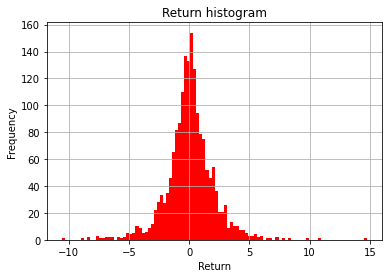

In [319]:
# Plot the histogram
data['Returns'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.title('Return histogram')
plt.show()

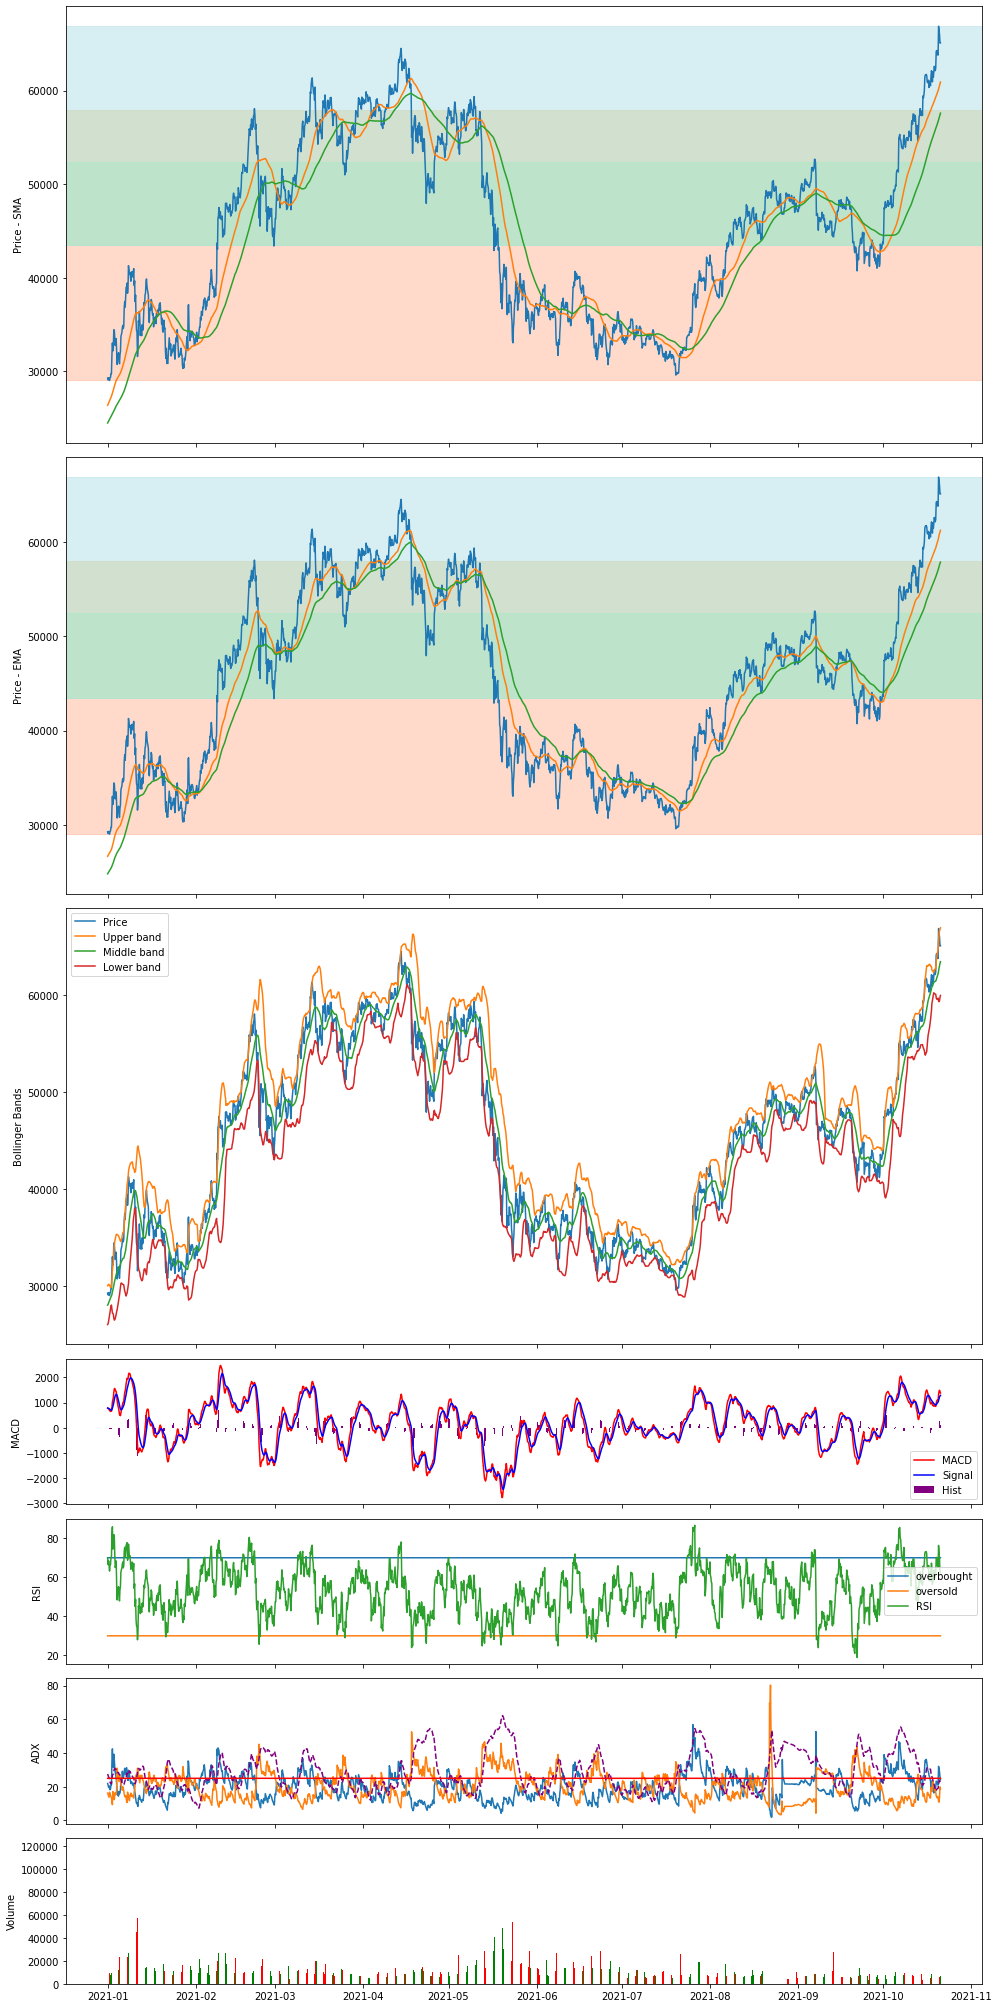

In [320]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA100']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA100']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.legend()
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.bar(data.index, data['MACDHist'], label='Hist', color="purple", width = timedelta(hours=1))
ax4.plot(data.index, data['MACDSignal'], label='Signal', color='blue')
ax4.legend()
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['RSI'], label='RSI')
ax5.legend()
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
# make bar plots and color differently depending on up/down for the day
pos = data['OpenPrice'] - data['ClosePrice'] < 0
neg = data['OpenPrice'] - data['ClosePrice'] > 0
ax7.bar(data.index[pos], data[pos]['Volume'], color='green', width = timedelta(hours=1))
ax7.bar(data.index[neg], data[neg]['Volume'], color='red', width = timedelta(hours=1))

#ax7.bar(data.index, data['Volume'] / 1000000, width = timedelta(hours=4))
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [321]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

In [322]:
from strategy_utils import get_cross_signal
from backtest_utils import signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_sma_cross = signal_strategy(price_data.copy(), signal, 'sma_cross')

In [323]:
from strategy_utils import get_cross_signal
from backtest_utils import signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_ema_cross = signal_strategy(price_data.copy(), signal, 'ema_cross')

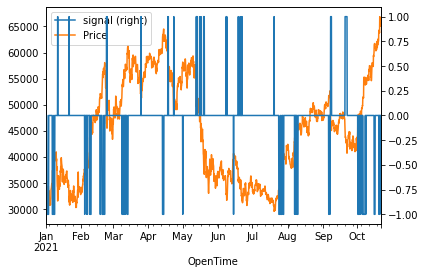

In [324]:
from strategy_utils import get_rsi_signal
from backtest_utils import signal_strategy

#signal = get_rsi_signal(data[['RSI']].copy())
signal = get_rsi_signal(data[['RSI']].copy(), overbought_value=70, oversold_value=30)

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

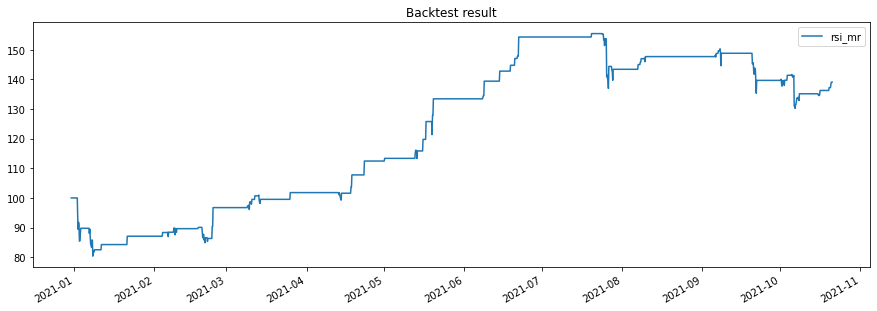

In [325]:
bt_rsi = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_rsi)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

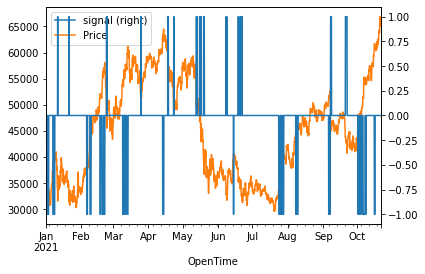

In [326]:
from strategy_utils import get_rsi_adx_signal
from backtest_utils import signal_strategy

signal = get_rsi_adx_signal(data[['RSI']].copy(), data[['ADX']].copy(), data[['DI+']].copy(), data[['DI-']].copy(), overbought_value=70.0, oversold_value=30.0)

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

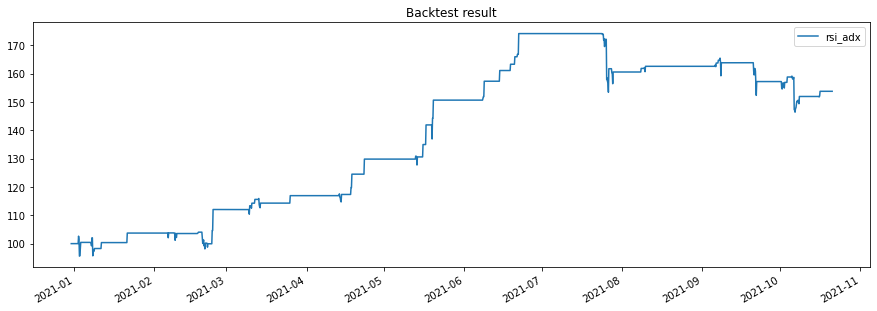

In [327]:
bt_rsi_adx = signal_strategy(price_data.copy(), signal, 'rsi_adx')

bt_result = bt.run(bt_rsi_adx)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [328]:
signal['2021-09-21 9:00:00':'2021-09-22 10:00:00']

,value
OpenTime,
2021-09-21 12:00:00,1.0
2021-09-21 16:00:00,1.0
2021-09-21 20:00:00,1.0
2021-09-22 00:00:00,0.0
2021-09-22 04:00:00,0.0
2021-09-22 08:00:00,0.0


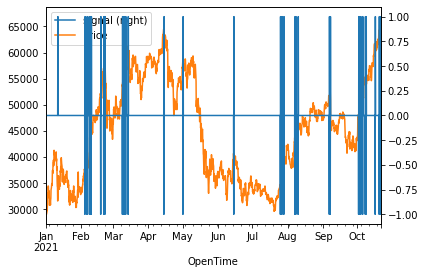

In [329]:
from strategy_utils import get_rsi_plus_signal
from backtest_utils import signal_strategy

signal = get_rsi_plus_signal(data[['RSI']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

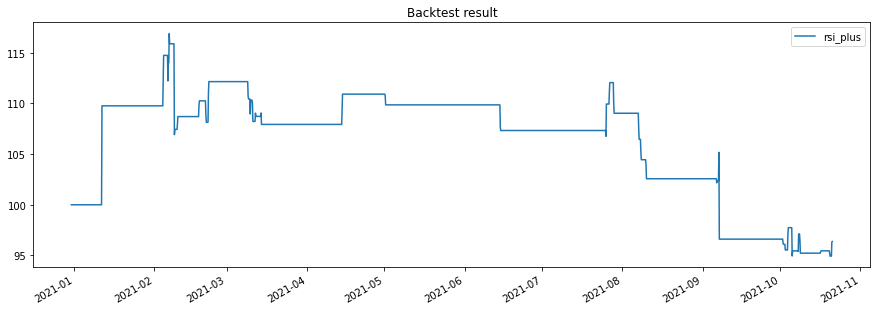

In [330]:
bt_rsi_plus = signal_strategy(price_data.copy(), signal, 'rsi_plus')

bt_result = bt.run(bt_rsi_plus)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

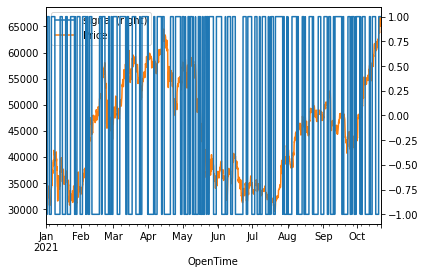

In [331]:
from strategy_utils import get_macd_signal
from backtest_utils import signal_strategy

signal = get_macd_signal(data[['MACDSignal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

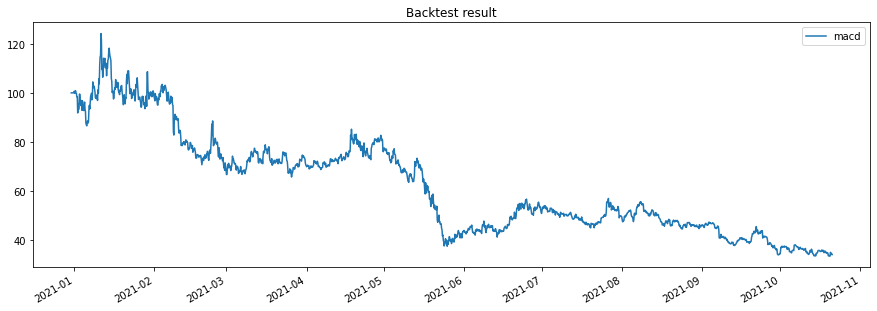

In [332]:
bt_macd = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

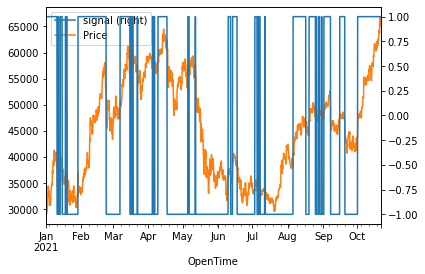

In [333]:
from strategy_utils import get_sma_macd_signal
from backtest_utils import signal_strategy

signal = get_sma_macd_signal(data[['ClosePrice']].copy(), data[['SMA50']].copy(), data[['SMA100']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

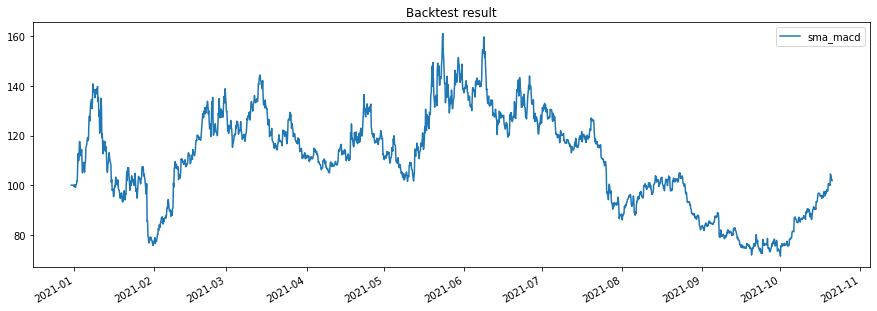

In [334]:
bt_sma_macd = signal_strategy(price_data.copy(), signal, 'sma_macd')

bt_result = bt.run(bt_sma_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

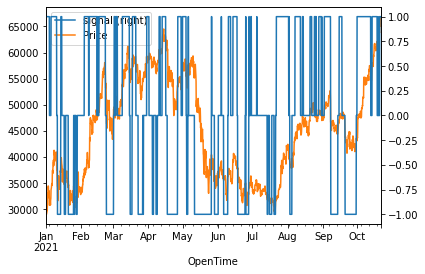

In [335]:
from strategy_utils import get_adx_macd_signal
from backtest_utils import signal_strategy

signal = get_adx_macd_signal(data[['MACD']].copy(), data[['DI+']].copy(), data[['DI-']].copy(), data[['ADX']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

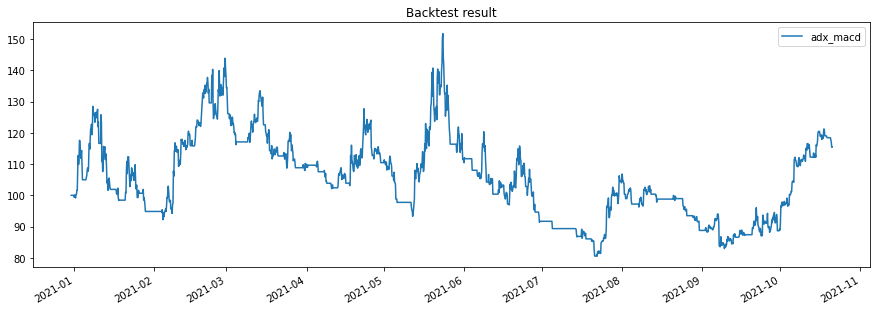

In [336]:
bt_adx_macd = signal_strategy(price_data.copy(), signal, 'adx_macd')

bt_result = bt.run(bt_adx_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

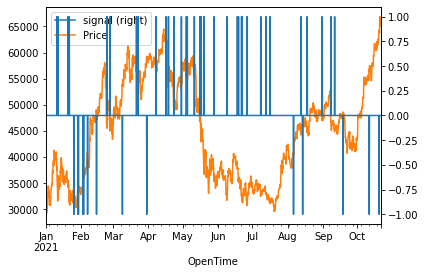

In [337]:
from strategy_utils import get_bbands_signal
from backtest_utils import signal_strategy

signal = get_bbands_signal(data[['ClosePrice']].copy(), data[['UpperBBand']].copy(), data[['LowerBBand']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

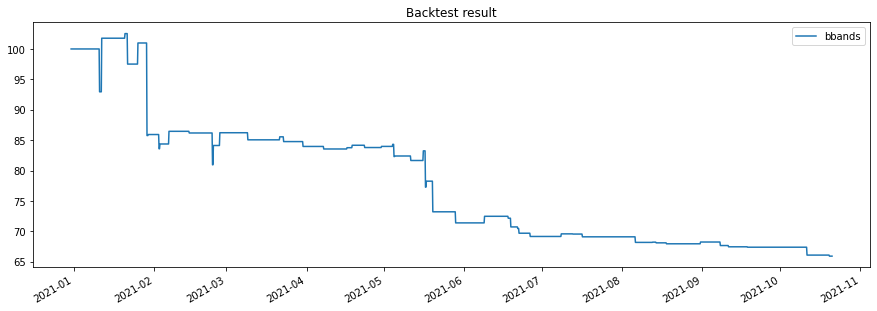

In [338]:
bt_bbands = signal_strategy(price_data.copy(), signal, 'bbands')

bt_result = bt.run(bt_bbands)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [339]:
data[['UpperBBand', 'MidiBBand', 'LowerBBand']]

,UpperBBand,MidiBBand,LowerBBand
OpenTime,,,
2021-01-01 00:00:00,30043.902853,28041.1890,26038.475147
2021-01-01 04:00:00,30143.429654,28141.8600,26140.290346
2021-01-01 08:00:00,30183.244324,28285.3045,26387.364676
2021-01-01 12:00:00,30147.463813,28422.9565,26698.449187
2021-01-01 16:00:00,30111.391310,28530.5885,26949.785690
...,...,...,...
2021-10-20 12:00:00,65636.359475,62526.0630,59415.766525
2021-10-20 16:00:00,66261.064385,62798.9480,59336.831615
2021-10-20 20:00:00,66664.274706,63060.8125,59457.350294


In [340]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
bt_sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
bt_sma10 = signal_above_strategy(price_data.copy(), data[['SMA10']].copy(), name='SMA10')
bt_sma20 = signal_above_strategy(price_data.copy(), data[['SMA20']].copy(), name='SMA20')
bt_sma30 = signal_above_strategy(price_data.copy(), data[['SMA30']].copy(), name='SMA30')
bt_sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')
bt_sma100 = signal_above_strategy(price_data.copy(), data[['SMA100']].copy(), name='SMA100')

# Create benchmark strategy backtest
bt_benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

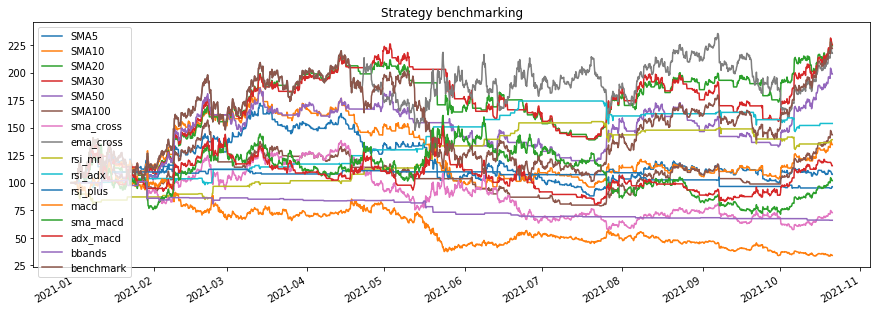

In [341]:
# Run all backtests and plot the resutls
bt_results = bt.run(bt_sma5,bt_sma10, bt_sma20, bt_sma30, bt_sma50, bt_sma100, 
                    bt_sma_cross, bt_ema_cross, bt_rsi, bt_rsi_adx, bt_rsi_plus, bt_macd, bt_sma_macd, bt_adx_macd, bt_bbands,
                    bt_benchmark)
# Plot results
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [342]:
bt_results.display()

Stat                 SMA5        SMA10       SMA20       SMA30       SMA50       SMA100      sma_cross    ema_cross    rsi_mr      rsi_adx     rsi_plus    macd        sma_macd    adx_macd    bbands      benchmark
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  -----------  -----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31   2020-12-31   2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31  2020-12-31
End                  2021-10-21  2021-10-21  2021-10-21  2021-10-21  2021-10-21  2021-10-21  2021-10-21   2021-10-21   2021-10-21  2021-10-21  2021-10-21  2021-10-21  2021-10-21  2021-10-21  2021-10-21  2021-10-21
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%        0.00%        0.00%       0.00%       0

In [343]:
# Obtain all backtest stats
resInfo = bt_results.stats
ordered_strategies = resInfo.loc['total_return'].sort_values(ascending=False)
print(ordered_strategies)

best_strategy = ''
if resInfo.loc['total_return'].sort_values(ascending=False).index[0] == 'benchmark':
    best_strategy = resInfo.loc['total_return'].sort_values(ascending=False).index[1]
else:
    best_strategy = resInfo.loc['total_return'].sort_values(ascending=False).index[0]

bt_best = bt_results.backtests[best_strategy]

SMA30        1.253362
SMA20        1.242971
benchmark    1.217958
ema_cross    1.174891
SMA50        0.986574
rsi_adx      0.537834
SMA100       0.435182
rsi_mr       0.390623
SMA10        0.345789
adx_macd     0.154396
SMA5          0.07587
sma_macd     0.018771
rsi_plus    -0.036271
sma_cross    -0.27168
bbands      -0.340897
macd        -0.659934
Name: total_return, dtype: object


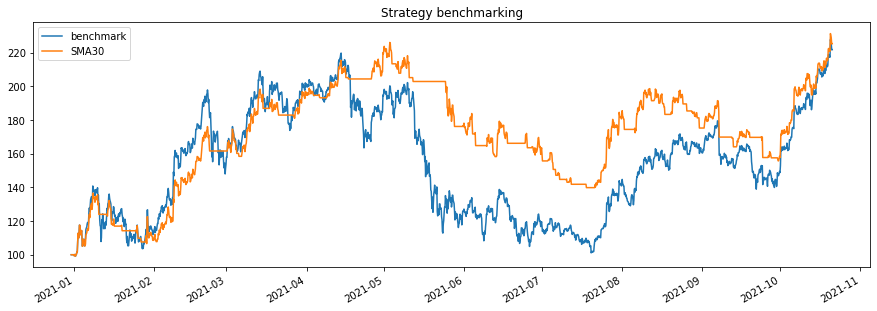

In [344]:
bt_results_best = bt.run(bt_benchmark, bt_best)
bt_results_best.plot(title='Strategy benchmarking')
plt.show()

In [345]:
bt_results_best.get_transactions(strategy_name=best_strategy)

,,price,quantity
Date,Security,,
2021-01-01 00:00:00,value,29278.40,34.0
2021-01-05 04:00:00,value,30817.77,-34.0
2021-01-05 08:00:00,value,31776.66,33.0
2021-01-10 16:00:00,value,37456.77,-33.0
2021-01-13 20:00:00,value,37371.38,33.0
...,...,...,...
2021-09-30 00:00:00,value,43591.23,36.0
2021-10-12 16:00:00,value,55329.78,-36.0
2021-10-12 20:00:00,value,55996.93,35.0


In [346]:
bt_results.get_transactions(strategy_name='rsi_adx')

,,price,quantity
Date,Security,,
2021-01-02 16:00:00,value,33027.20,-31.0
2021-01-03 04:00:00,value,34452.34,3.0
2021-01-03 12:00:00,value,33506.62,-2.0
2021-01-03 16:00:00,value,32772.21,30.0
2021-01-07 12:00:00,value,38970.42,-26.0
...,...,...,...
2021-10-07 20:00:00,value,53785.22,27.0
2021-10-08 04:00:00,value,54829.39,-28.0
2021-10-08 12:00:00,value,54324.84,28.0


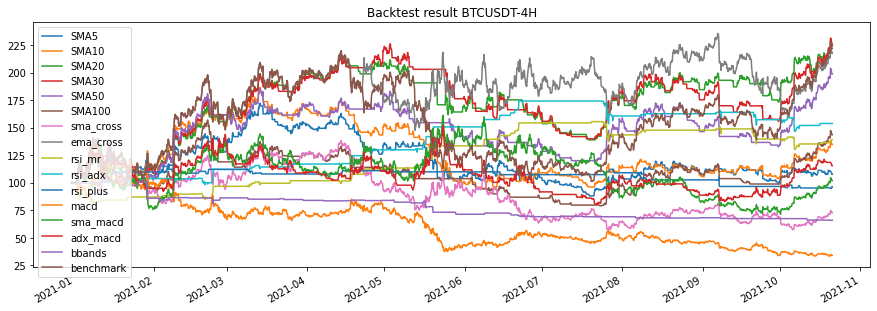

          SMA5   SMA10    SMA20    SMA30  ... sma_macd adx_macd   bbands benchmark
mtd      6.20%  27.95%   27.33%   42.26%  ...   39.47%   29.38%   -2.18%    48.40%
3m      13.59%  34.31%   58.42%   58.09%  ...  -12.68%   43.29%   -4.60%   102.10%
6m     -21.65%  -7.69%   12.82%   10.23%  ...  -16.68%    1.03%  -21.68%    20.98%
ytd      7.59%  34.58%  124.30%  125.34%  ...    1.88%   15.44%  -34.09%   121.80%
1y        nan%    nan%     nan%     nan%  ...     nan%     nan%     nan%      nan%
3y        nan%    nan%     nan%     nan%  ...     nan%     nan%     nan%      nan%
5y        nan%    nan%     nan%     nan%  ...     nan%     nan%     nan%      nan%
10y       nan%    nan%     nan%     nan%  ...     nan%     nan%     nan%      nan%
incep    9.51%  44.62%  172.80%  174.37%  ...    2.34%   19.53%  -40.42%   169.03%

[9 rows x 16 columns]


In [347]:
# Plot the backtest result
title = 'Backtest result ' + pair + '-' + strategy_interval
bt_results.plot(title=title)
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)

# Tests

<AxesSubplot:title={'center':'Strategy benchmarking BTCUSDT-4H'}>

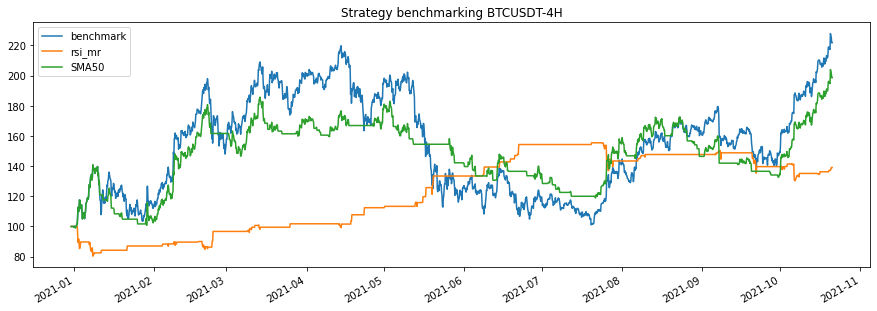

In [350]:
bt_results_test = bt.run(bt_benchmark, bt_rsi, bt_sma50)
title = 'Strategy benchmarking ' + pair + '-' + strategy_interval
bt_results_test.plot(title=title)
